In [51]:
import pandas as pd
data = pd.read_csv('/Users/fipm/code/abefarkas/Thalassa_Regime_Classifier/raw_data/data_set_v2.csv')

In [52]:
data.head(3)



,primary_key,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,bp5,...,ap16,as16,ap17,as17,ap18,as18,ap19,as19,ap20,as20
0,2022-05-19 00:00:00,28700.600000,0.082333,28699.100000,0.017000,28699.000000,1.609667,28697.400000,0.105000,28696.8,...,28704.6,0.268333,28704.833333,0.534333,28704.966667,0.014000,28705.133333,0.027000,28705.300000,0.192000
1,2022-05-19 00:00:01,28700.600000,0.046000,28699.400000,0.012333,28699.033333,0.934000,28697.933333,0.534333,28697.0,...,28704.2,0.207000,28704.366667,0.045667,28704.466667,0.001667,28704.700000,0.101333,28704.866667,0.051000
2,2022-05-19 00:00:02,28695.633333,0.285500,28694.766667,0.077333,28693.733333,0.506000,28693.600000,0.978667,28692.5,...,28702.3,0.885667,28702.400000,0.553333,28702.733333,0.098667,28702.833333,0.001667,28702.966667,0.505333


In [53]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone, timedelta
import joblib

class DataModelPipeline():
    def __init__(self):
        self.preprocessing = Pipeline([
            ('Imputer', SimpleImputer(strategy = 'mean')),
            # ('scaler', MinMaxScaler()),
            ])
        self.data = None
        self.y = None
        self.X = None

    def financial_features(self, data):
        self.data = data.copy()

        # unix_timestamp = lambda x: datetime.fromtimestamp(x/1000.0, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        str2date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        # self.data['primary_key']=self.data['ts'].apply(unix_timestamp).apply(str2date)
        self.data['primary_key']=self.data['primary_key'].apply(str2date)
        
        
        
        
        # self.data['less30s']=self.data['primary_key'].dt.second<30
        # self.data['primary_key']=self.data['primary_key'].dt.strftime('%Y-%m-%d %H:%M')+self.data['less30s'].apply(lambda x: ':15' if x==True else ':45')
        # self.data.drop(columns=['less30s'], inplace=True)
        

        # WAP
        self.data['WAP'] = (self.data['bp1']*self.data['bs1']
                +self.data['bp2']*self.data['bs2']
                +self.data['ap1']*self.data['as1']
                +self.data['ap2']*self.data['as2'])/(self.data['bs1']+
                                            self.data['bs2']+
                                            self.data['as1']+
                                            self.data['as2'])

        # log_price
        self.data['log_price'] = 100*np.log(self.data['WAP'])

        # log_returns
        self.data['log_returns'] = self.data.log_price.diff()


        # other features
        self.data['spread'] = ((self.data['ap1']/self.data['bp1']) - 1)
        self.data['spread_sq']=self.data['spread']*self.data['spread']
        
        
        self.data['full_bid_depth'] = self.data[['bs1', 'bs2', 'bs3','bs4', 'bs5', 'bs6','bs7', 'bs8', 'bs9','bs10',
                            'bs11', 'bs12', 'bs13','bs14', 'bs15', 'bs16','bs17', 'bs18', 'bs19','bs20']].sum(axis=1)
        self.data['full_ask_depth'] = self.data[['as1', 'as2', 'as3','as4', 'as5', 'as6','as7', 'as8', 'as9','as10',
                            'as11', 'as12', 'as13','as14', 'as15', 'as16','as17', 'as18', 'as19','as20']].sum(axis=1)
        self.data['BBAOFI'] = (self.data['bs1']-self.data['as1'])/(self.data['bs1']+self.data['as1'])
        self.data['First2OFI'] = ((self.data['bs1']+self.data['bs2']) - (self.data['as1']+self.data['as2']))/ ((self.data['bs1']+self.data['bs2']) + (self.data['as1']+self.data['as2']))
        self.data['FDOFI'] = (self.data['full_bid_depth']-self.data['full_ask_depth'])/(self.data['full_bid_depth']+self.data['full_ask_depth'])
         
        # realized_volatility
        sigma = lambda x: (np.nansum(x**2))**0.5
        y = self.data[['log_returns']]

        rolling=2*60
        y = y.rolling(rolling).apply(sigma)

        
        primary_key=self.data['primary_key']
        
        self.data = self.data.rolling(rolling).mean()        
        self.data['realized_volatility']=y.values
        self.data['primary_key']=primary_key
        
        #####
        
        # sigma = lambda x: (np.nansum(x['log_returns']**2))**0.5
        # y = self.data[['primary_key','log_returns']].groupby(['primary_key']).apply(sigma)

        # self.data = self.data.groupby(['primary_key']).mean()
        # self.data.reset_index(drop=False, inplace=True)
        # self.data['realized_volatility']=y.values
            
        return self.data

    def pipeline(self, data):
        data = data.dropna().reset_index(drop=True)
        # self.y = data[['primary_key','realized_volatility']].set_index('primary_key')
        self.y = data[['realized_volatility']]

        X = data.drop(columns=['realized_volatility','primary_key'])
        self.X = pd.DataFrame(self.preprocessing.fit_transform(X), columns=self.preprocessing.get_feature_names_out())
        return self.y, self.X

    def predict(self, model, steps=1):
        # only works for arima
        #n = pd.DataFrame.from_dict({'realized_volatility':new_data})
        #y_new = pd.concat((self.y, n)).reset_index(drop=True)
        new_model = model.apply(self.y)
        predictions = new_model.forecast(steps)
        predictions = pd.DataFrame.from_dict({'realized_volatility':predictions.values})
        y_new = pd.concat((self.y, predictions)).reset_index(drop=True)
        return y_new

In [54]:

data_model_pipeline = DataModelPipeline()
# construct finantial features
df = data_model_pipeline.financial_features(data)
# getting endogenous and exogenous variables to be used
# to train a model
y, X = data_model_pipeline.pipeline(df)




/var/folders/91/6wbfy1kd3c54vx64tq8sck_00000gn/T/ipykernel_1323/374373280.py:74: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['primary_key'], dtype='object')
  self.data = self.data.rolling(rolling).mean()


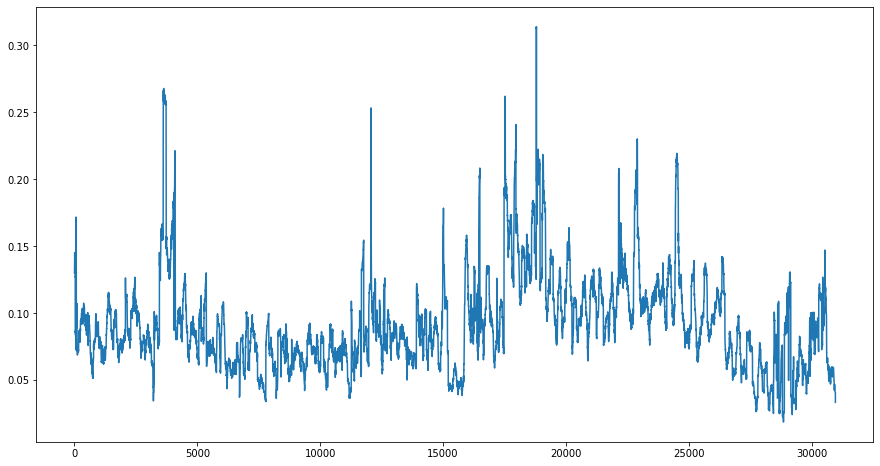

In [55]:
import matplotlib.pyplot  as plt
fig = plt.figure(figsize=(15,8))
plt.plot(y)

In [87]:
# from statsmodels.tsa.arima.model import ARIMA
# # 1. initialize the model
# arima = ARIMA(y, order=(1, 0,0))
# # 2. fit the models
# arima_fit = arima.fit()
# arima_fit.summary()

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


end_train = int(.8*len(y))
y_train = y[:end_train]
X_train = X[:end_train]
y_test = y[(end_train+1):]
X_test = X[(end_train+1):]


for lag in range(31,50,1):

    new_y = pd.concat((
        y_train,
        y_train.shift(30).rename(columns={'realized_volatility':'lag_y'}),
        # y_train.shift(lag).rename(columns={'realized_volatility':'lag_y_2'}),
        X_train['spread'].shift(30),
        X_train['spread_sq'].shift(30),
        X_train['BBAOFI'].shift(30),        
        X_train['FDOFI'].shift(30),            
            # X['First2OFI'].shift(lag), 
            # X['full_bid_depth'].shift(lag),
            # X['full_ask_depth'].shift(lag),
        ), axis=1).dropna()
    
    new_y_test = pd.concat((
        y_test,
        y_test.shift(30).rename(columns={'realized_volatility':'lag_y'}),
        # y_test.shift(lag).rename(columns={'realized_volatility':'lag_y_2'}),
        X_test['spread'].shift(30),
        X_test['spread_sq'].shift(30),
        X_test['BBAOFI'].shift(30),        
        X_test['FDOFI'].shift(30),            
            # X['First2OFI'].shift(lag), 
            # X['full_bid_depth'].shift(lag),
            # X['full_ask_depth'].shift(lag),
        ), axis=1).dropna()

    y_=new_y['realized_volatility']
    X_=new_y.drop(columns='realized_volatility')
    
    y_t=new_y_test['realized_volatility']
    X_t=new_y_test.drop(columns='realized_volatility')
    
    
    reg = LinearRegression(positive=True)
    reg.fit(X=X_, y=y_)
    print([lag, reg.score(X=X_, y=y_), reg.score(X=X_t, y=y_t)])





[31, 0.7451552769759011, 0.625757981649028]
[32, 0.7451552769759011, 0.625757981649028]
[33, 0.7451552769759011, 0.625757981649028]
[34, 0.7451552769759011, 0.625757981649028]
[35, 0.7451552769759011, 0.625757981649028]
[36, 0.7451552769759011, 0.625757981649028]
[37, 0.7451552769759011, 0.625757981649028]
[38, 0.7451552769759011, 0.625757981649028]
[39, 0.7451552769759011, 0.625757981649028]
[40, 0.7451552769759011, 0.625757981649028]
[41, 0.7451552769759011, 0.625757981649028]
[42, 0.7451552769759011, 0.625757981649028]
[43, 0.7451552769759011, 0.625757981649028]
[44, 0.7451552769759011, 0.625757981649028]
[45, 0.7451552769759011, 0.625757981649028]
[46, 0.7451552769759011, 0.625757981649028]
[47, 0.7451552769759011, 0.625757981649028]
[48, 0.7451552769759011, 0.625757981649028]
[49, 0.7451552769759011, 0.625757981649028]


In [86]:
bids = [1,2]
asks = [3,4]

print(bids+asks)

np.max(bids+asks)

E_t(sigma_t+30)

[1, 2, 3, 4]


4

In [67]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

class PositiveLinearRegression(BaseEstimator, RegressorMixin):
    """Fits a logistic regression model on tree embeddings.
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs        
        self.lr = LinearRegression(**kwargs)
    
    def fit(self, X, y=None):
        self.lr.fit(X, y)
    
    def predict(self, X, y=None):        
        preds = np.exp(self.lr.predict(X))
        return preds
        

In [72]:
lag=30
new_y = pd.concat((
        y_train,
        y_train.shift(30).rename(columns={'realized_volatility':'lag_y'}),
        y_train.shift(2*lag).rename(columns={'realized_volatility':'lag_y_2'}),
        X_train['spread'].shift(lag),
        X_train['spread_sq'].shift(lag),
        X_train['BBAOFI'].shift(lag),        
        X_train['FDOFI'].shift(lag),            
            # X['First2OFI'].shift(lag), 
            # X['full_bid_depth'].shift(lag),
            # X['full_ask_depth'].shift(lag),
        ), axis=1).dropna()
    
new_y_test = pd.concat((
        y_test,
        y_test.shift(30).rename(columns={'realized_volatility':'lag_y'}),
        y_test.shift(2*lag).rename(columns={'realized_volatility':'lag_y_2'}),
        X_test['spread'].shift(lag),
        X_test['spread_sq'].shift(lag),
        X_test['BBAOFI'].shift(lag),        
        X_test['FDOFI'].shift(lag),            
            # X['First2OFI'].shift(lag), 
            # X['full_bid_depth'].shift(lag),
            # X['full_ask_depth'].shift(lag),
        ), axis=1).dropna()

y_=new_y['realized_volatility']
X_=new_y.drop(columns='realized_volatility')

y_t=new_y_test['realized_volatility']
X_t=new_y_test.drop(columns='realized_volatility')

In [97]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

class EnsenbleRegresorF(BaseEstimator, RegressorMixin):
    """Fits a logistic regression model on tree embeddings.
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.gbr = GradientBoostingRegressor(n_estimators=100, **kwargs)
        self.r = Ridge()
        self.lr = LinearRegression()
    
    def fit(self, X, y=None):
        self.gbr.fit(X.values, y)
        X_emb = self.gbr.apply(X).reshape(X.shape[0], -1)
        X_emb2 = self.r.fit(X.values, y).predict(X.values).reshape(X.shape[0], -1)
        X_emb = np.concatenate((X_emb,X_emb2),axis=1)
        self.lr.fit(X_emb, y)
    
    def predict(self, X, y=None):        
        X_emb = self.gbr.apply(X.values).reshape(X.shape[0], -1)
        X_emb2 = self.r.predict(X.values).reshape(X.shape[0], -1)
        X_emb = np.concatenate((X_emb,X_emb2),axis=1)
        preds = self.lr.predict(X_emb)
        return preds
    
    
reg = EnsenbleRegresorF()    
reg.fit(X_, y_)
[reg.score(X_, y_), reg.score(X_t, y_t)]    


/Users/fipm/.pyenv/versions/3.8.12/envs/thalassa/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


[0.7789877453068577, 0.551014732471206]

In [76]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.linear_model import SGDClassifier

gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
lr = LinearRegression(positive=True)


adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

# grid = {
#         'gradientboostingregressor__n_estimators': stats.randint(50,300),
#         'gradientboostingregressor__learning_rate':stats.uniform(0.05,0.3),
#         'gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
        
#     }



reg = StackingRegressor(
    estimators=[
                ("gboost", gboost),
                # ("adaboost", adaboost),
                # ("ridge", ridge), 
                # ("svm_rbf", svm)
                ],    
    final_estimator=lr,
    cv=None,
    n_jobs=-1
)
reg.fit(X_, y_)
[reg.score(X_, y_), reg.score(X_t, y_t)]


[0.8145177017388842, 0.5251258894246498]

In [ ]:
reg.score(X_t, y_t)

In [139]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

lag=30
new_y = pd.concat((
        y_train,
        y_train.shift(lag).rename(columns={'realized_volatility':'lag_y'}),
        X_train['spread'].shift(lag),
        X_train['spread_sq'].shift(lag),
        X_train['BBAOFI'].shift(lag),        
        X_train['FDOFI'].shift(lag),            
        ), axis=1).dropna()


pca = PCA(n_components=1)
pca.fit(new_y.values[:,1:])
X_emb = pca.transform(new_y.values[:,1:])
X_emb = np.concatenate((new_y.values[:,0].reshape(new_y.shape[0],-1),X_emb),axis=1)
new_y = pd.DataFrame(X_emb, columns=('volatility', 'predictors'))
gm = GaussianMixture(n_components=2, random_state=0).fit(new_y)
labels = gm.predict(new_y)
probs = gm.predict_proba(new_y)[:,0]

# labels=labels>0
print('0 :'+str(np.sum(labels==0)))
print('1 :'+str(np.sum(labels==1)))
print('2 :'+str(np.sum(labels==2)))
print('3 :'+str(np.sum(labels==3)))

new_y2 = pd.concat((new_y,pd.DataFrame({'labels':labels, 'probs':probs})), axis=1).dropna()
new_y2



0 :19257
1 :5485
2 :0
3 :0


,volatility,predictors,labels,probs
0,0.127662,-0.181285,1,0.384273
1,0.085429,-0.182555,0,0.941042
2,0.085429,-0.183700,0,0.941397
3,0.085429,-0.184600,0,0.941675
4,0.086361,-0.189608,0,0.941615
...,...,...,...,...
24737,0.097799,-0.139823,0,0.880303
24738,0.097847,-0.134277,0,0.876956
24739,0.097847,-0.139297,0,0.879725
24740,0.097847,-0.139906,0,0.880061


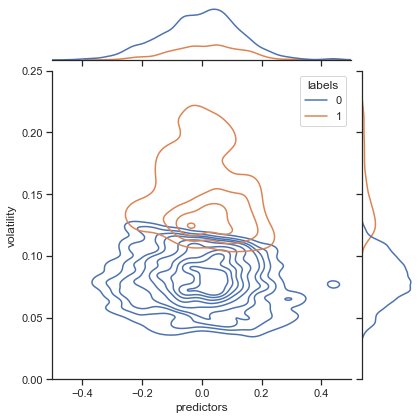

In [140]:
import seaborn as sns
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=new_y2,
    x="predictors", y="volatility", hue='labels',
    xlim=[-.5,.5],
    ylim=[0,.25],
    kind="kde",
)

/Users/fipm/.pyenv/versions/3.8.12/envs/thalassa/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/fipm/.pyenv/versions/3.8.12/envs/thalassa/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:title={'center':'Probability of being in a low-variance regime'}>

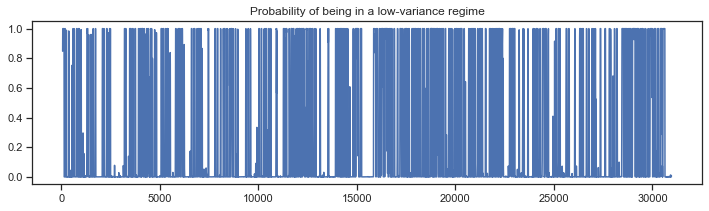

In [322]:
import statsmodels.api as sm
lag=30
new_y = pd.concat((
    y,
    y.shift(lag).rename(columns={'realized_volatility':'lag_y'}),
    y.shift(2*lag).rename(columns={'realized_volatility':'lag_y'}),
    X['spread'].shift(lag),
    # # X['full_bid_depth'].shift(lag),
    # # X['full_ask_depth'].shift(lag),
    X['BBAOFI'].shift(lag),
    # # X['First2OFI'].shift(lag), 
    X['FDOFI'].shift(lag),            
    ), axis=1).dropna()

y_=new_y['realized_volatility']
X_=new_y.drop(columns='realized_volatility')


mod_hamilton = sm.tsa.MarkovRegression(
    y_, k_regimes=2, 
    exog=X_,
    switching_variance=True
)
res_hamilton = mod_hamilton.fit()
res_hamilton.summary()
res_hamilton.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a low-variance regime", figsize=(12, 3)
)

In [325]:
np.sum(res_hamilton.smoothed_marginal_probabilities[0]>.75)

8318